In [ ]:
# Install dependencies
!pip install inference inference-gpu supervision opencv-python
!pip install git+https://github.com/roboflow/sports.git

  Using cached supervision-0.24.0-py3-none-any.whl.metadata (14 kB)
  Using cached opencv_python-4.10.0.84-cp37-abi3-win_amd64.whl.metadata (20 kB)
  Using cached aiortc-1.9.0-cp38-abi3-win_amd64.whl.metadata (5.6 kB)
  Using cached APScheduler-3.10.1-py3-none-any.whl.metadata (5.7 kB)
  Using cached Cython-3.0.0-cp311-cp311-win_amd64.whl.metadata (3.2 kB)
  Using cached python_dotenv-1.0.1-py3-none-any.whl.metadata (23 kB)
CollectiSoccerFrameAnalyzer(.111,>=0.100 (from inference)
  Using cached fastapi-0.110.3-py3-none-any.whl.metadata (24 kB)
  Using cached numpy-1.26.4-cp311-cp311-win_amd64.whl.metadata (61 kB)
  Using cached piexif-1.1.3-py2.py3-none-any.whl.metadata (3.7 kB)
  Using cached pillow-10.4.0-cp311-cp311-win_amd64.whl.metadata (9.3 kB)
  Using cached prometheus_fastapi_instrumentator-6.0.0-py3-none-any.whl.metadata (13 kB)
  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
  Using cached rich-13.5.2-py3-none-any.whl.metadata (18 kB)
  Using cached supervi


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


  Cloning https://github.com/roboflow/sports.git to c:\users\isss1\appdata\local\temp\pip-req-build-purxh4qf
  Resolved https://github.com/roboflow/sports.git to commit 06053616f1f8a8ae1fa936eb00dcdc2e4f888bb1
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached transformers-4.46.2-py3-none-any.whl.metadata (44 kB)
  Using cached umap_learn-0.5.7-py3-none-any.whl.metadata (21 kB)
  Using cached scikit_learn-1.5.2-cp311-cp311-win_amd64.whl.metadata (13 kB)
  Using cached sentencepiece-0.2.0-cp311-cp311-win_amd64.whl.metadata (8.3 kB)
  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached threadpoolctl-3.5.0-py3-none-any.whl.metadata (13 kB)
     ---------------------------------------- 0.0/41.5 kB ? eta -:--:--
     ---------------------------- --------- 30.7/41.5 kB 435.7 kB/s eta 0:00:01
     -------------------------------------- 41.5/41.5 kB 505.0 kB/s eta 0:00:00
  Using cached safetensors-0.4.5-

  Running command git clone --filter=blob:none --quiet https://github.com/roboflow/sports.git 'C:\Users\isss1\AppData\Local\Temp\pip-req-build-purxh4qf'

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
# Summary of CUDA and Nvidia GPU details

!nvidia-smi

Wed Nov 27 15:39:04 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 561.09                 Driver Version: 561.09         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060      WDDM  |   00000000:01:00.0  On |                  N/A |
|  0%   52C    P8             N/A /  115W |    3063MiB /   8188MiB |     22%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
# Checking if CUDA exists on local machine
!nvcc --version

# Install CUDA version of Torch to leverage GPU acceleration
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118
     ---------------------------------------- 0.0/2.7 GB ? eta -:--:--
     ---------------------------------------- 0.0/2.7 GB 2.6 MB/s eta 0:17:02
     ---------------------------------------- 0.0/2.7 GB 4.5 MB/s eta 0:10:05
     ---------------------------------------- 0.0/2.7 GB 4.8 MB/s eta 0:09:19
     ---------------------------------------- 0.0/2.7 GB 4.7 MB/s eta 0:09:40
     ---------------------------------------- 0.0/2.7 GB 5.2 MB/s eta 0:08:38
     ---------------------------------------- 0.0/2.7 GB 5.5 MB/s eta 0:08:09
     ---------------------------------------- 0.0/2.7 GB 5.7 MB/s eta 0:07:56
     ---------------------------------------- 0.0/2.7 GB 6.0 MB/s eta 0:07:31
     ---------------------------------------- 0.0/2.7 GB 6.1 MB/s eta 0:07:25
     ---------------------------------------- 0.0/2.7 GB 6.2 MB/s eta 0:07:16
     ---------------------------------------- 0.0/2.7 GB 6.2 MB/s eta 0:07:15
     -------


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



     --------------------- ------------------ 1.4/2.7 GB 5.0 MB/s eta 0:04:15
     --------------------- ------------------ 1.4/2.7 GB 5.0 MB/s eta 0:04:14
     --------------------- ------------------ 1.4/2.7 GB 5.0 MB/s eta 0:04:14
     --------------------- ------------------ 1.4/2.7 GB 5.0 MB/s eta 0:04:14
     --------------------- ------------------ 1.4/2.7 GB 4.9 MB/s eta 0:04:16
     --------------------- ------------------ 1.4/2.7 GB 4.9 MB/s eta 0:04:20
     --------------------- ------------------ 1.4/2.7 GB 4.7 MB/s eta 0:04:26
     --------------------- ------------------ 1.4/2.7 GB 4.7 MB/s eta 0:04:28
     --------------------- ------------------ 1.4/2.7 GB 4.7 MB/s eta 0:04:30
     --------------------- ------------------ 1.4/2.7 GB 4.7 MB/s eta 0:04:28
     --------------------- ------------------ 1.4/2.7 GB 4.6 MB/s eta 0:04:32
     --------------------- ------------------ 1.4/2.7 GB 4.6 MB/s eta 0:04:33
     --------------------- ------------------ 1.4/2.7 GB 4.6 MB

In [2]:
import torch

# Checking if CUDA is available
if torch.cuda.is_available():
    print("CUDA is available. Training on GPU!")
# If it isn't, just train it on the CPU
else:
    print("CUDA is not available. Training on CPU.")
    
!nvcc --version

CUDA is available. Training on GPU!
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:41:10_Pacific_Daylight_Time_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


In [7]:
import numpy as np
import cv2

class ViewTransformer:
    def __init__(self, source: np.ndarray, target: np.ndarray) -> None:
        if source.shape != target.shape:
            raise ValueError(
                "Source and target must have the same shape.")
        if source.shape[1] != 2:
            raise ValueError(
                f"Source and target points must be 2D coordinates. They are currently {source.shape} and {target.shape}.")

        source = source.astype(np.float32)
        target = target.astype(np.float32)

        self.m, _ = cv2.findHomography(source, target, method=cv2.RANSAC, ransacReprojThreshold=2)
        if self.m is None:
            raise ValueError(
                "Homography matrix could not be calculated.")

    def transformPoints(self, points: np.ndarray) -> np.ndarray:
        if points.size == 0:
            return points

        if points.shape[1] != 2:
            raise ValueError("Points must be 2D coordinates.")

        points = points.reshape(-1, 1, 2).astype(np.float32)
        points = cv2.perspectiveTransform(points, self.m)
        
        return points.reshape(-1, 2).astype(np.float32)

In [8]:

from dataclasses import dataclass, field
from typing import List, Tuple

# Copied and modified the SoccerPitchConfiguration class from the Roboflow Sports Repository: https://github.com/roboflow/sports/blob/main/sports/configs/soccer.py
@dataclass
class SoccerPitchConfiguration:
    width: int = 7000  # [cm]
    length: int = 12000  # [cm]
    penalty_box_width: int = 4100  # [cm]
    penalty_box_length: int = 2015  # [cm]
    goal_box_width: int = 1832  # [cm]
    goal_box_length: int = 550  # [cm]
    centre_circle_radius: int = 915  # [cm]
    penalty_spot_distance: int = 1100  # [cm]
    
    # Added this to address the issue with the post keypoints being detected slightly closer than they were
    post_size: int = 200 # [cm]

    @property
    def vertices(self) -> List[Tuple[int, int]]:
        return [
            (0, 0),  # 1
            (0, (self.width - self.penalty_box_width) / 2),  # 2
            (0, (self.width - self.goal_box_width) / 2),  # 3
            (0, (self.width + self.goal_box_width) / 2),  # 4
            (0, (self.width + self.penalty_box_width) / 2),  # 5
            (0, self.width),  # 6
            (self.goal_box_length, (self.width - self.goal_box_width) / 2),  # 7
            (self.goal_box_length, (self.width + self.goal_box_width) / 2),  # 8
            (self.penalty_spot_distance, self.width / 2),  # 9
            (self.penalty_box_length, (self.width - self.penalty_box_width) / 2),  # 10
            (self.penalty_box_length, (self.width - self.goal_box_width) / 2),  # 11
            (self.penalty_box_length, (self.width + self.goal_box_width) / 2),  # 12
            (self.penalty_box_length, (self.width + self.penalty_box_width) / 2),  # 13
            (self.length / 2, 0),  # 14
            (self.length / 2, self.width / 2 - self.centre_circle_radius),  # 15
            (self.length / 2, self.width / 2 + self.centre_circle_radius),  # 16
            (self.length / 2, self.width),  # 17
            (
                self.length - self.penalty_box_length,
                (self.width - self.penalty_box_width) / 2
            ),  # 18
            (
                self.length - self.penalty_box_length,
                (self.width - self.goal_box_width) / 2
            ),  # 19
            (
                self.length - self.penalty_box_length,
                (self.width + self.goal_box_width) / 2
            ),  # 20
            (
                self.length - self.penalty_box_length,
                (self.width + self.penalty_box_width) / 2
            ),  # 21
            (self.length - self.penalty_spot_distance, self.width / 2),  # 22
            (
                self.length - self.goal_box_length,
                (self.width - self.goal_box_width) / 2
            ),  # 23
            (
                self.length - self.goal_box_length,
                (self.width + self.goal_box_width) / 2
            ),  # 24
            (self.length, 0),  # 25
            (self.length, (self.width - self.penalty_box_width) / 2),  # 26
            (self.length, (self.width - self.goal_box_width) / 2),  # 27
            (self.length, (self.width + self.goal_box_width) / 2),  # 28
            (self.length, (self.width + self.penalty_box_width) / 2),  # 29
            (self.length, self.width),  # 30
            (self.length / 2 - self.centre_circle_radius, self.width / 2),  # 31
            (self.length / 2 + self.centre_circle_radius, self.width / 2),  # 32
            (self.post_size, (self.width + self.goal_box_width / 2) / 2), # 33
            (self.post_size, (self.width - self.goal_box_width / 2) / 2), # 34
            (self.length - self.post_size, (self.width - self.goal_box_width / 2) / 2), #35
            (self.length - self.post_size, (self.width + self.goal_box_width / 2) / 2), #36
        ]

    edges: List[Tuple[int, int]] = field(default_factory=lambda: [
        (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (7, 8),
        (10, 11), (11, 12), (12, 13), (14, 15), (15, 16),
        (16, 17), (18, 19), (19, 20), (20, 21), (23, 24),
        (25, 26), (26, 27), (27, 28), (28, 29), (29, 30),
        (1, 14), (2, 10), (3, 7), (4, 8), (5, 13), (6, 17),
        (14, 25), (18, 26), (23, 27), (24, 28), (21, 29), (17, 30)
    ])

    labels: List[str] = field(default_factory=lambda: [
        "01", "02", "03", "04", "05", "06", "07", "08", "09", "10",
        "11", "12", "13", "15", "16", "17", "18", "20", "21", "22",
        "23", "24", "25", "26", "27", "28", "29", "30", "31", "32",
        "14", "19"
    ])

    colors: List[str] = field(default_factory=lambda: [
        "#FF1493", "#FF1493", "#FF1493", "#FF1493", "#FF1493", "#FF1493",
        "#FF1493", "#FF1493", "#FF1493", "#FF1493", "#FF1493", "#FF1493",
        "#FF1493", "#00BFFF", "#00BFFF", "#00BFFF", "#00BFFF", "#FF6347",
        "#FF6347", "#FF6347", "#FF6347", "#FF6347", "#FF6347", "#FF6347",
        "#FF6347", "#FF6347", "#FF6347", "#FF6347", "#FF6347", "#FF6347",
        "#00BFFF", "#00BFFF"
    ])
    
test = SoccerPitchConfiguration()


In [9]:

from sports.annotators.soccer import draw_pitch, draw_points_on_pitch
import supervision as sv
from inference import get_model
import numpy as np
import cv2
import math

# CONSTANTS TO DEFINE COMMON ATTRIBUTES

# IDs
# The YOLO object detection model assigns the following classes (represented as numbers) to ball detection models
# I included these constants to make the code more readable
BALL_CLASS_ID = 0
GOALKEEPER_CLASS_ID = 1
NO_TEAM_PLAYER_CLASS_ID = 2
REFEREE_CLASS_ID = 3

# These constants were ones that I defined, when I clustered the players into two different teams
TEAM_ONE_PLAYER_CLASS_ID = 4
TEAM_TWO_PLAYER_CLASS_ID = 5

# Confidence levels
# These are defined as constants so that the user can easily change how restrictive they want to be with filtering out certain detections
# The higher the number, the more restrictive the filtering will be (e.g. 0.7 means 70% confidence is required)
# Confidence level to identify the pitch object in the keypoint detection model
PITCH_CONFIDENCE_LEVEL = 0.7
# Confidence level to keep a specific keypoint in the keypoint detection model
KEYPOINT_CONFIDENCE_LEVEL = 0.5
# Confidence level to identify a player, refereree, goalkeeper or ball in the object detection model
OBJECT_CONFIDENCE_LEVEL = 0.3

# These are trained models that are used for keypoint detection model, with the number after the slash indicating the version
OBJECT_DETECTION_MODEL_NAME = "soccer-computer-vision-acffy/3"
KEYPOINT_DETECTION_MODEL_NAME = "soccer-field-detection-sbywb/9"

# Maximum computed distance to indicate that a player is in possesssion of the ball
BALL_THRESHOLD_DISTANCE = 1800

keypointModel = get_model(model_id=KEYPOINT_DETECTION_MODEL_NAME)
objectModel = get_model(model_id=OBJECT_DETECTION_MODEL_NAME)

# Common functionality to be run on soccer frames
class SoccerFrameAnalyzer:
    def __init__(self, image, obfuscatedFrame=None, tracker=None, lastFrame=None, areKeypointsPrecomputed=False, isObfuscatedModel=False, teamClassifier=None) -> None:
        self.image = image.copy()
        self.isTracked = bool(tracker)
        self.isObfuscatedTeamClassification = isObfuscatedModel
        self.obfuscatedFrame=obfuscatedFrame
        self.teamClassifier = teamClassifier
        self.objectDetections = self.makeObjectDetections(tracker=tracker)
        self.updateDetectionsWithTeams()
        
        # Can re-use a transformation matrix or compute a new one 
        if not areKeypointsPrecomputed:
            try:
                self.keypoints = self.obtainKeypoints()
                self.transformer = self.createTransformer()
            # If an error occurs while computing the homography matrix, then use the last ones
            except Exception:
                if lastFrame == None:
                    raise Exception("The homography matrix could not be computed, and as a result, this SoccerFrame instance could not be calculated.")
                
                self.transformer = lastFrame.transformer
                self.keypoints = lastFrame.keypoints
        else:
            self.transformer = lastFrame.transformer
            self.keypoints = lastFrame.keypoints 
            
        self.computeAllCoords()
    
    # Updates the player detections with 
    def updateDetectionsWithTeams(self):
        # Can perform obfuscated image analysis or regular team classification analysis
        if self.isObfuscatedTeamClassification:
            analysisImage = self.obfuscatedFrame.copy()
        else:
            analysisImage = self.image.copy()
        
        playersDetections = self.getObjectClassDetections(NO_TEAM_PLAYER_CLASS_ID)
        playerCrops = [sv.crop_image(analysisImage, xyxy) for xyxy in playersDetections.xyxy]   
        teamDetections = self.teamClassifier.predict(playerCrops)
        
        # Chaning all the player IDs to corresponding player team IDs (ID 4 and 5)
        teamDetections = [teamDetection + REFEREE_CLASS_ID + 1 for teamDetection in teamDetections]
        
        j = 0
        
        detectionClasses = self.objectDetections.class_id
        
        for i, detection in enumerate(detectionClasses):
            if detection == NO_TEAM_PLAYER_CLASS_ID:
                detectionClasses[i] = teamDetections[j]
                j += 1
                
        self.objectDetections.class_id = detectionClasses
        
    def makeObjectDetections(self, tracker=None):
        result = objectModel.infer(self.image, confidence=OBJECT_CONFIDENCE_LEVEL)[0]
        
        objectDetections = sv.Detections.from_inference(result)
        
        if tracker:
            objectDetections = tracker.update_with_detections(objectDetections)
            
        return objectDetections
    
    # Helper function to deal with the issue of coordinate scalars to indexnig properly, even when converted in standard ways
    def convertScalarCoordsToArr(self, scalarCoords):
        strContents = str(scalarCoords)[1:-1].split('.')
        floatCoords = []
        
        for coords in strContents:
            if coords:
                floatCoords.append(float(coords))
        
        return floatCoords
        
    # Converts values from my kepoint detection model into the order that is needed for homography
    def getMappedKeypointArr(self, arr):
        # Center points are often confused with each other (e.g. left center point is taken to be the right center point)
        # This swaps the values around based on what their x, y coordinates should be
        coord15List = self.convertScalarCoordsToArr(arr[15])
        coord17List = self.convertScalarCoordsToArr(arr[17])
        
        if coord15List and coord17List:
            if coord15List[0] < coord17List[0]:
                leftCenterCoord = arr[15]
                rightCenterCoord = arr[17]
            else:
                leftCenterCoord = arr[17]    
                rightCenterCoord = arr[15]        
            
            mappedArr = np.array([arr[0], arr[5], arr[9], arr[6], arr[2], arr[1], arr[8], 
                                arr[7], arr[10], arr[4], arr[12], arr[11], arr[3], 
                                arr[18], 
                                arr[16], arr[14], arr[13], arr[21], arr[31], arr[30], 
                                arr[22], arr[28], arr[26], arr[25], arr[19], arr[20], 
                                arr[27], arr[24], arr[23], arr[29],  leftCenterCoord, rightCenterCoord,
                                arr[32], arr[33], arr[34], arr[35]])
            
            return mappedArr
        
        return None
    
    def getGrayscaledImage(self, image):
        imageCopy = image.copy()
        
        return cv2.cvtColor(imageCopy, cv2.COLOR_BGR2GRAY)

    # Uses a keypoint detection model to return pitch keypoints
    def getPitchKeypoints(self):
        result = keypointModel.infer(self.image, confidence=PITCH_CONFIDENCE_LEVEL)[0] 

        extractedResult = sv.KeyPoints.from_inference(result)
        
        adjustedXy = self.getMappedKeypointArr(extractedResult.xy[0])[np.newaxis, ...]
        adjustedConfidence = self.getMappedKeypointArr(extractedResult.confidence[0])[np.newaxis, ...]
        adjustedResult = sv.KeyPoints(xy=adjustedXy, confidence=adjustedConfidence)
        
        return adjustedResult
        
        
    # Returns filtered keypoints
    def obtainKeypoints(self):
        keypoints = self.getPitchKeypoints()

        self.filter = self.getKeypointsFilter(keypoints)
        xy = keypoints.xy[self.filter]
        confidence = keypoints.confidence[self.filter]
        
        return sv.KeyPoints(xy=xy[np.newaxis, ...], confidence=confidence[np.newaxis, ...])
        
    def getKeypointsFilter(self, keypoints):
        filter = keypoints.confidence > KEYPOINT_CONFIDENCE_LEVEL

        return filter

    # Takes a set of actual and target keypoints, compares them and returns the Homography matrix
    def createTransformer(self):
        source = self.keypoints.xy[0]
        target = np.array(SoccerPitchConfiguration().vertices)[self.filter[0]]
        
        return ViewTransformer(source=source, target=target)

    def getObjectClassDetections(self, classId):
        return self.objectDetections[self.objectDetections.class_id == classId]

    def getCoordsFromDetections(self):
        return self.objectDetections.get_anchors_coordinates(anchor=sv.Position.CENTER)

    def getPitchTransformedCoords(self, classDetections):
        return self.transformer.transformPoints(points=classDetections.get_anchors_coordinates(anchor=sv.Position.CENTER))

    def getClassCoords(self, classId):
        classDetections = self.getObjectClassDetections(classId)
        classCoords = self.getPitchTransformedCoords(classDetections)
        
        return classCoords

    def getAnnotatedImageWithSpecifiedCoords(self, image, coords, faceColor, edgeColor):
        return draw_points_on_pitch(
            config=SoccerPitchConfiguration(),
            xy=coords,
            face_color=faceColor,
            edge_color=edgeColor,
            radius=8,
            thickness=1,
            pitch=image
        )

    # Takes object detections and annotates the footage
    # Keypoint detections are optional, and will not be rendered if they're not passed
    def getAnnotatedFootage(self):
        frame = self.image.copy()
        
        # Output detections image, with keypoints and object detection
        boxAnnotator = sv.BoxAnnotator()
        teamOneBoxAnnotator = sv.BoxAnnotator(color=sv.Color.RED)
        teamTwoBoxAnnotator = sv.BoxAnnotator(color=sv.Color.BLUE)
        labelAnnotator = sv.LabelAnnotator(color=sv.Color.BLACK)
        
        if self.isTracked:
            objectLabels = [ f"#{trackerId} {confidence:.2f}" for trackerId, confidence in zip(self.objectDetections.tracker_id, self.objectDetections.confidence) ]
        else: 
            objectLabels = [ f"{className} {confidence:.2f}" for className, confidence in zip(self.objectDetections['class_name'], self.objectDetections.confidence) ]
        
        annotatedFrame = boxAnnotator.annotate(scene=frame, detections=self.getObjectClassDetections(REFEREE_CLASS_ID))
        annotatedFrame = boxAnnotator.annotate(scene=frame, detections=self.getObjectClassDetections(BALL_CLASS_ID))
        annotatedFrame = boxAnnotator.annotate(scene=frame, detections=self.getObjectClassDetections(GOALKEEPER_CLASS_ID))
        annotatedFrame = teamOneBoxAnnotator.annotate(scene=frame, detections=self.getObjectClassDetections(TEAM_ONE_PLAYER_CLASS_ID))
        annotatedFrame = teamTwoBoxAnnotator.annotate(scene=frame, detections=self.getObjectClassDetections(TEAM_TWO_PLAYER_CLASS_ID))
        annotatedFrame = labelAnnotator.annotate(scene=annotatedFrame, detections=self.objectDetections, labels=objectLabels)

        # Plotting all available keypoints, but showing their confidence levels
        if self.keypoints:
            keypointAnnotator = sv.VertexAnnotator(radius=12, color=sv.Color.GREEN)
            annotatedFrame = keypointAnnotator.annotate(annotatedFrame, self.keypoints)
        
        return annotatedFrame
    
    # Uses Pythagorean theorem to compute the distance between two coordinates
    def calculateCoordinateDistance(self, firstCoords, secondCoords):
        xDiff = firstCoords[0] - secondCoords[0]
        yDiff = firstCoords[1] - secondCoords[1]
        
        # Border cases
        if xDiff == 0:
            distance = yDiff
        elif yDiff == 0:
            distance = xDiff = 0
        # Main case: pythagorean theorem between differences
        else:
            distance = math.sqrt(math.pow(xDiff, 2) + math.pow(yDiff, 2))
            
        return distance
    
    def computeAllCoords(self):
        # Transforming detections for the homography matrix
        self.ballCoords = self.getClassCoords(BALL_CLASS_ID)
        self.goalkeeperCoords = self.getClassCoords(GOALKEEPER_CLASS_ID)
        self.teamOneCoords = self.getClassCoords(TEAM_ONE_PLAYER_CLASS_ID)
        self.teamTwoCoords = self.getClassCoords(TEAM_TWO_PLAYER_CLASS_ID)
        self.refereeCoords = self.getClassCoords(REFEREE_CLASS_ID)
        
    # Returns nothing if it doesn't go under the threshold for the maximum distance
    # This only considers players, not goalkeepers
    def getClosestTeamToBall(self):
        if len(self.ballCoords) == 0:
            return None
        
        teamOneMin = self.getMinimumDistanceWithBall(self.teamOneCoords, self.ballCoords[0])
        teamTwoMin = self.getMinimumDistanceWithBall(self.teamTwoCoords, self.ballCoords[0])
        
        if not teamOneMin and not teamTwoMin or teamOneMin >= BALL_THRESHOLD_DISTANCE and teamTwoMin >= BALL_THRESHOLD_DISTANCE:
            return None
        elif teamOneMin < teamTwoMin or teamOneMin and not teamTwoMin:
            return TEAM_ONE_PLAYER_CLASS_ID
        else:
            return TEAM_TWO_PLAYER_CLASS_ID
        
    # Works under the assumption that there is only 1 identified ball
    def getMinimumDistanceWithBall(self, teamCoords, ballCoord):
        min = BALL_THRESHOLD_DISTANCE
        
        for coord in teamCoords:
            distance = self.calculateCoordinateDistance(ballCoord, coord)
            
            if distance != None and distance < min:
                min = distance
                
        return min
    
    def isBallDetected(self):
        return len(self.ballCoords) > 0

    def getAnnotatedPitch(self):            
        pitchImage = draw_pitch(SoccerPitchConfiguration())
        
        annotatedPitch = self.getAnnotatedImageWithSpecifiedCoords(pitchImage, self.ballCoords, sv.Color.WHITE, sv.Color.BLACK)
        annotatedPitch = self.getAnnotatedImageWithSpecifiedCoords(annotatedPitch, self.goalkeeperCoords, sv.Color.GREEN, sv.Color.BLACK)
        annotatedPitch = self.getAnnotatedImageWithSpecifiedCoords(annotatedPitch, self.teamOneCoords, sv.Color.RED, sv.Color.BLACK)
        annotatedPitch = self.getAnnotatedImageWithSpecifiedCoords(annotatedPitch, self.teamTwoCoords, sv.Color.BLUE, sv.Color.BLACK)
        annotatedPitch = self.getAnnotatedImageWithSpecifiedCoords(annotatedPitch, self.refereeCoords, sv.Color.YELLOW, sv.Color.BLACK)
        
        height = annotatedPitch.shape[0]
        width = annotatedPitch.shape[1]
        
        return cv2.resize(annotatedPitch, (width, height))

In [10]:
from tqdm import tqdm
from sports.common.team import TeamClassifier
import torch
import torchvision
import cv2
import numpy as np

KEYPOINT_STRIDE = 4
TEAM_CLASSIFCATION_MAX_DATASET_SIZE = 60

# Stores all frames of the video and has the ability to create annotated videos
class SoccerFootageAnalyzer:
    def __init__(self, path, useObfuscatedTeamClassification=False) -> None:
        self.path = path
        self.tracker = self.createTracker()
        
        self.rawFrames = self.extractRawFrames()
        self.isObfuscatedModel = useObfuscatedTeamClassification
        
        if self.isObfuscatedModel:
            self.obfuscatedFrames = self.createObfuscatedImages()
            self.teamClassificationModel = self.createTeamClassificationModel(self.obfuscatedFrames)
        else:
            self.obfuscatedFrames = []
            self.teamClassificationModel = self.createTeamClassificationModel(self.rawFrames)
            
        self.soccerFrames = self.createSoccerFrames()

    def getPossession(self):
        # These represent the amount of times that a frame has indicated that a player is in posession
        teamOneCounts = 0
        teamTwoCounts = 0
        
        for frame in self.soccerFrames:
            closestTeam = frame.getClosestTeamToBall()
            
            if closestTeam != None:
                if closestTeam == TEAM_ONE_PLAYER_CLASS_ID:
                    teamOneCounts += 1
                else:
                    teamTwoCounts += 1
                    
        # Compute posession from overall counts
        totalCount = teamOneCounts + teamTwoCounts
        
        return {
            'teamOne': teamOneCounts / totalCount,
            'teamTwo': teamTwoCounts / totalCount
        }

    def createTracker(self):
        tracker = sv.ByteTrack()
        tracker.reset()
        
        return tracker
    
    def extractRawFrames(self):
        rawFrames = []
        
        for frame in sv.get_video_frames_generator(source_path=self.path):
            rawFrames.append(frame)
            
        return rawFrames
    
    # Obtains a team classification model using SIGLip and UMAP
    def createTeamClassificationModel(self, frames):
        crops = []
        
        for frame in tqdm(frames[:TEAM_CLASSIFCATION_MAX_DATASET_SIZE], desc='Training team classification model...'):
            result = objectModel.infer(frame, confidence=OBJECT_CONFIDENCE_LEVEL)[0]
            detections = sv.Detections.from_inference(result)
            playersDetections = detections[detections.class_id == NO_TEAM_PLAYER_CLASS_ID]
            
            # Cropping images around the bounding boxes of the detections
            playersCrops = [sv.crop_image(frame, xyxy) for xyxy in playersDetections.xyxy]
            crops += playersCrops

        teamClassifier = TeamClassifier(device="cuda")
        teamClassifier.fit(crops)
            
        return teamClassifier
    
    def createObfuscatedImages(self):
        obfuscatedImages = []
        
        for frame in self.rawFrames:
            obfuscatedImages.append(self.getObfuscatedImage(frame))
            
        return obfuscatedImages
    
    # For clustering of players into different roles, not teams (uses obfuscation)
    def getObfuscatedImage(self, image):
        inputImage = image.copy()
        
        # Load pre-trained Mask R-CNN model from torchvision
        model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
        model.eval()
        
        imageRgb = cv2.cvtColor(inputImage, cv2.COLOR_BGR2RGB)

        # Convert image to tensor
        transform = torchvision.transforms.ToTensor()
        imageTensor = transform(imageRgb).unsqueeze(0)

        # Run the image through the model to get predictions
        with torch.no_grad():
            prediction = model(imageTensor)

        # Get the masks for all detected objects (class 1 = person)
        masks = prediction[0]['masks']
        labels = prediction[0]['labels']
        # scores = prediction[0]['scores']

        # Filter masks for class "person" (label = 1)
        personMasks = masks[labels == 1]

        # Create an empty mask for the jerseys
        jerseyMask = np.zeros(imageRgb.shape[:2], dtype=np.uint8)

        for mask in personMasks:
            mask = mask[0] > 0.5
            mask = mask.numpy().astype(np.uint8)
            jerseyMask = np.maximum(jerseyMask, mask)

        imageHsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

        lowerWhite = np.array([0, 0, 200])
        upperWhite = np.array([180, 30, 255])

        maskWhite = cv2.inRange(imageHsv, lowerWhite, upperWhite)
        combinedMask = np.maximum(jerseyMask, maskWhite)
        inputImage[combinedMask == 1] = [255, 255, 255]
        
        return inputImage
    
    # Creates all the soccer frames with soccer frames object
    def createSoccerFrames(self):
        latestSoccerFrame = None
        soccerFrames = []
        
        for i, frame in enumerate(self.rawFrames):
            if len(self.obfuscatedFrames) > 0:
                obfuscatedFrame = self.obfuscatedFrames[i]
            else:
                obfuscatedFrame = None
            
            # Only re-compute transformation matrices and keypoints every few frames (for efficiency)
            if i % KEYPOINT_STRIDE == 0:
                latestSoccerFrame = SoccerFrameAnalyzer(frame, obfuscatedFrame=obfuscatedFrame, tracker=self.tracker, lastFrame=latestSoccerFrame, areKeypointsPrecomputed=False, isObfuscatedModel=self.isObfuscatedModel, teamClassifier=self.teamClassificationModel)
            else:
                latestSoccerFrame = SoccerFrameAnalyzer(frame, obfuscatedFrame=obfuscatedFrame, tracker=self.tracker, lastFrame=latestSoccerFrame, areKeypointsPrecomputed=True, isObfuscatedModel=self.isObfuscatedModel, teamClassifier=self.teamClassificationModel)
            
            soccerFrames.append(latestSoccerFrame)
                
            
        return soccerFrames
    
    # Adds ball coordinates (where it can) to frames that do not have ball detectiosn
    def interpolateMissedBallDetections(self):
        right = len(self.soccerFrames) - 1
        
        # Iterating backwards, retroactively update ball coordinates
        # If a ball isn't detected in it's last frame, use the last ball coodinate as a placeholder value
        while right > 0:
            rightFrame = self.soccerFrames[right]
            
            # If a ball is detected on the right pointer, then update ball coordinates of frames if they do not have a ball
            if rightFrame.isBallDetected():
                left = right - 1
                leftFrame = self.soccerFrames[left]
                undetectedConsecutiveBallCount = 0
                curCoords = rightFrame.ballCoords
                
                # Counting how many consecutive frames do not have a ball detection
                while left >= 0 and not leftFrame.isBallDetected():
                    undetectedConsecutiveBallCount += 1
                    left -= 1
                    leftFrame = self.soccerFrames[left]
                    
                if left >= 0:
                    # Comput xy distance between the right frame and the left frame that has real ball detections
                    # First index 0 is for selecting the first ball
                    xDis = leftFrame.ballCoords[0][0] - rightFrame.ballCoords[0][0]
                    yDis = leftFrame.ballCoords[0][1] - rightFrame.ballCoords[0][1]
                    
                    left = right - 1
                    leftFrame = self.soccerFrames[left]
                    
                    # Once a ball is seen in one of the leftwardes frames, no need to continue interpolation
                    for _ in range(undetectedConsecutiveBallCount):
                        curCoords[0][0] += xDis / (undetectedConsecutiveBallCount + 1)
                        curCoords[0][1] += yDis / (undetectedConsecutiveBallCount + 1)
                        
                        # Adding most recent ball detection to frame that has none
                        # Creating a deepy copy of the arary to ensure that it is not modified by following iterations
                        leftFrame.ballCoords = curCoords.copy()
                        
                        left -= 1
                        leftFrame = self.soccerFrames[left]
                
                right = left
                
            # If no ball is detected on the current right pointer, move the pointer
            else:
                right -= 1
                
    # Creates annotated footage video
    def createAnnotatedFootageVideo(self, targetPath):
        dimensions = self.getImageDimensions(self.soccerFrames[0].getAnnotatedFootage())
        output=cv2.VideoWriter(targetPath, -1, 30, dimensions)
        
        for frame in self.soccerFrames:
            annotatedFrame = frame.getAnnotatedFootage()
            output.write(annotatedFrame)
            
        self.releaseVideo(output)
            
    # Creates annotated pitch video
    def createAnnotatedPitchVideo(self, targetPath):
        dimensions = self.getImageDimensions(self.soccerFrames[0].getAnnotatedPitch())
        
        output=cv2.VideoWriter(targetPath, -1, 30, dimensions)

        for frame in self.soccerFrames:
            output.write(frame.getAnnotatedPitch())
            
        self.releaseVideo(output)
        
    def getImageDimensions(self, image):
        return (image.shape[1], image.shape[0])
    
    # Complete video creation and release resources
    def releaseVideo(self, output):
        cv2.destroyAllWindows()
        output.release()
        
# Proceses frame and returns a SoccerFrame instance
def processVideoFrame(frame):    
    return SoccerFrameAnalyzer(frame)

In [ ]:
# Reference: Copied and revised from https://github.com/roboflow/sports/blob/main/sports/common/team.py
from typing import Generator, Iterable, List, TypeVar

import numpy as np
import supervision as sv
import torch
import umap
from sklearn.cluster import KMeans
from tqdm import tqdm
from transformers import AutoProcessor, SiglipVisionModel

V = TypeVar("V")

SIGLIP_MODEL_PATH = 'google/siglip-base-patch16-224'


def create_batches(
    sequence: Iterable[V], batch_size: int
) -> Generator[List[V], None, None]:
    """
    Generate batches from a sequence with a specified batch size.

    Args:
        sequence (Iterable[V]): The input sequence to be batched.
        batch_size (int): The size of each batch.

    Yields:
        Generator[List[V], None, None]: A generator yielding batches of the input
            sequence.
    """
    batch_size = max(batch_size, 1)
    current_batch = []
    for element in sequence:
        if len(current_batch) == batch_size:
            yield current_batch
            current_batch = []
        current_batch.append(element)
    if current_batch:
        yield current_batch


class TeamClassifier:
    """
    A classifier that uses a pre-trained SiglipVisionModel for feature extraction,
    UMAP for dimensionality reduction, and KMeans for clustering.
    """
    def __init__(self, device: str = 'cpu', batch_size: int = 32):
        """
       Initialize the TeamClassifier with device and batch size.

       Args:
           device (str): The device to run the model on ('cpu' or 'cuda').
           batch_size (int): The batch size for processing images.
       """
        self.device = device
        self.batch_size = batch_size
        self.features_model = SiglipVisionModel.from_pretrained(
            SIGLIP_MODEL_PATH).to(device)
        self.processor = AutoProcessor.from_pretrained(SIGLIP_MODEL_PATH)
        self.reducer = umap.UMAP(n_components=3)
        self.cluster_model = KMeans(n_clusters=2)

    def extract_features(self, crops: List[np.ndarray]) -> np.ndarray:
        """
        Extract features from a list of image crops using the pre-trained
            SiglipVisionModel.

        Args:
            crops (List[np.ndarray]): List of image crops.

        Returns:
            np.ndarray: Extracted features as a numpy array.
        """
        crops = [sv.cv2_to_pillow(crop) for crop in crops]
        batches = create_batches(crops, self.batch_size)
        data = []
        with torch.no_grad():
            for batch in tqdm(batches, desc='Embedding extraction'):
                inputs = self.processor(
                    images=batch, return_tensors="pt").to(self.device)
                outputs = self.features_model(**inputs)
                embeddings = torch.mean(outputs.last_hidden_state, dim=1).cpu().numpy()
                data.append(embeddings)

        return np.concatenate(data)

    def fit(self, crops: List[np.ndarray]) -> None:
        """
        Fit the classifier model on a list of image crops.

        Args:
            crops (List[np.ndarray]): List of image crops.
        """
        data = self.extract_features(crops)
        projections = self.reducer.fit_transform(data)
        self.cluster_model.fit(projections)

    def predict(self, crops: List[np.ndarray]) -> np.ndarray:
        """
        Predict the cluster labels for a list of image crops.

        Args:
            crops (List[np.ndarray]): List of image crops.

        Returns:
            np.ndarray: Predicted cluster labels.
        """
        if len(crops) == 0:
            return np.array([])

        data = self.extract_features(crops)
        projections = self.reducer.transform(data)
        
        return self.cluster_model.predict(projections)

collecting crops: 30it [00:05,  5.49it/s]
Embedding extraction: 8it [00:01,  4.30it/s]
Embedding extraction: 1it [00:00, 11.70it/s]


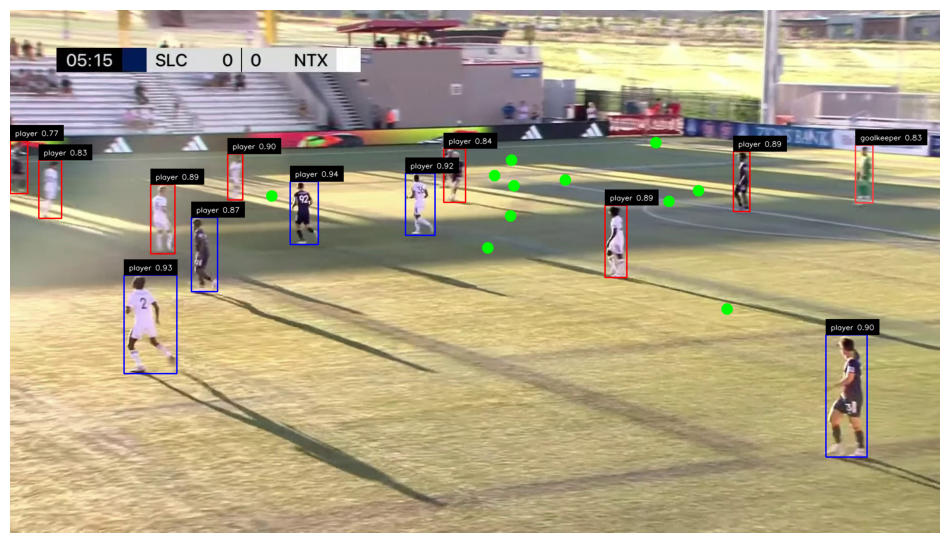

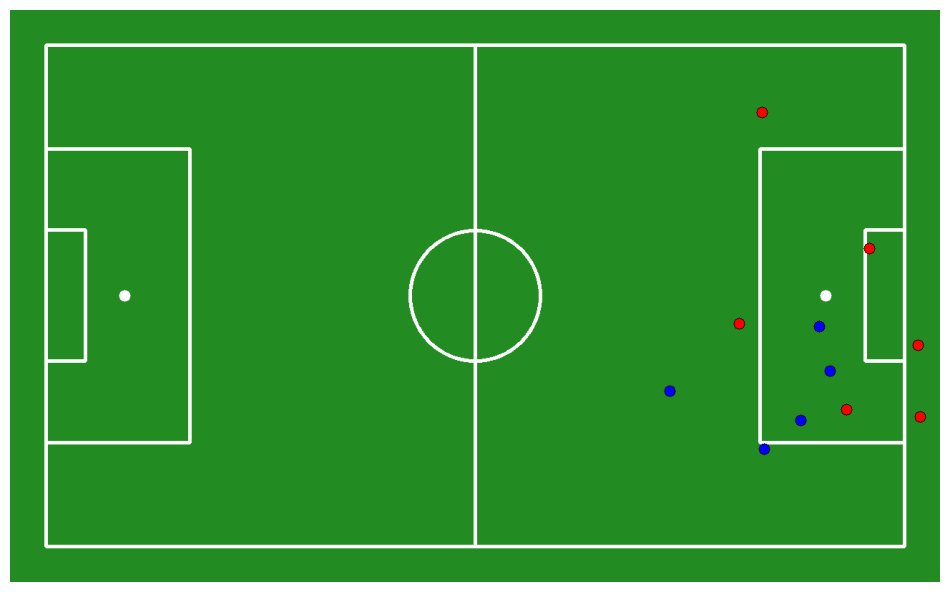

In [12]:
import supervision as sv
from tqdm import tqdm

SOURCE_VIDEO_PATH = "example-input/clip_17.mp4"
PLAYER_ID = 2
STRIDE = 30

frame_generator = sv.get_video_frames_generator(
    source_path=SOURCE_VIDEO_PATH, stride=STRIDE)


crops = []
for frame in tqdm(frame_generator, desc='collecting crops'):
    result = objectModel.infer(frame, confidence=OBJECT_CONFIDENCE_LEVEL)[0]
    detections = sv.Detections.from_inference(result)
    
    playersDetections = detections[detections.class_id == NO_TEAM_PLAYER_CLASS_ID]
    playersCrops = [sv.crop_image(frame, xyxy) for xyxy in playersDetections.xyxy]
    crops += playersCrops

teamClassifier = TeamClassifier(device="cuda")
teamClassifier.fit(crops)

# Perspective transformation
fileName = f"images-pitch/frame242.jpg"
image = cv2.imread(fileName)

exampleFrame = SoccerFrameAnalyzer(image, teamClassifier=teamClassifier, isObfuscatedModel=False)

sv.plot_image(exampleFrame.getAnnotatedFootage())
sv.plot_image(exampleFrame.getAnnotatedPitch())

In [ ]:
import supervision as sv
from tqdm import tqdm
from sports.common.team import TeamClassifier

SOURCE_VIDEO_PATH = "example-input/clip_12.mp4"
PLAYER_ID = 2
STRIDE = 30

def createObfuscatedImages(self):
    obfuscatedImages = []
    
    for frame in self.rawFrames:
        obfuscatedImages.append(self.getObfuscatedImage(frame))
        
    return obfuscatedImages

# For clustering of players into different roles, not teams (uses obfuscation)
def getObfuscatedImage(image):
    inputImage = image.copy()
    
    # Load pre-trained Mask R-CNN model from torchvision
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
    model.eval()
    
    imageRgb = cv2.cvtColor(inputImage, cv2.COLOR_BGR2RGB)

    # Convert image to tensor
    transform = torchvision.transforms.ToTensor()
    imageTensor = transform(imageRgb).unsqueeze(0)

    # Run the image through the model to get predictions
    with torch.no_grad():
        prediction = model(imageTensor)

    # Get the masks for all detected objects (class 1 = person)
    masks = prediction[0]['masks']
    labels = prediction[0]['labels']
    # scores = prediction[0]['scores']

    # Filter masks for class "person" (label = 1)
    personMasks = masks[labels == 1]

    # Create an empty mask for the jerseys
    jerseyMask = np.zeros(imageRgb.shape[:2], dtype=np.uint8)

    for mask in personMasks:
        mask = mask[0] > 0.5
        mask = mask.numpy().astype(np.uint8)
        jerseyMask = np.maximum(jerseyMask, mask)

    imageHsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    lowerWhite = np.array([0, 0, 200])
    upperWhite = np.array([180, 30, 255])

    maskWhite = cv2.inRange(imageHsv, lowerWhite, upperWhite)
    combinedMask = np.maximum(jerseyMask, maskWhite)
    inputImage[combinedMask == 1] = [255, 255, 255]
    
    return inputImage

frame_generator = sv.get_video_frames_generator(
    source_path=SOURCE_VIDEO_PATH, stride=STRIDE)


crops = []
for frame in tqdm(frame_generator, desc='collecting crops'):
    result = objectModel.infer(frame, confidence=OBJECT_CONFIDENCE_LEVEL)[0]
    detections = sv.Detections.from_inference(result)
    
    obfFrame = getObfuscatedImage(frame)
    
    playersDetections = detections[detections.class_id == NO_TEAM_PLAYER_CLASS_ID]
    playersCrops = [sv.crop_image(obfFrame, xyxy) for xyxy in playersDetections.xyxy]
    crops += playersCrops

teamClassifier = TeamClassifier(device="cuda")
teamClassifier.fit(crops)

# Perspective transformation
fileName = f"images-pitch/frame185.jpg"
image = cv2.imread(fileName)

exampleFrame = SoccerFrameAnalyzer(image, teamClassifier=teamClassifier, isObfuscatedModel=True, obfuscatedFrame=obfFrame)

sv.plot_image(exampleFrame.getAnnotatedFootage())
sv.plot_image(exampleFrame.getAnnotatedPitch())

In [37]:
print("Computing frames...")
# Can switch obfuscated classification on or off upon intialization
footageAnalyzer = SoccerFootageAnalyzer('example-input/clip_13.mp4', useObfuscatedTeamClassification=False)
footageAnalyzer.interpolateMissedBallDetections()

print("Creating annotated footage video...")
footageAnalyzer.createAnnotatedFootageVideo('annotated-footage/annotated-footage.mp4')
print("Finished creating video.")

print("Creating annotated pitch video...")
footageAnalyzer.createAnnotatedPitchVideo('annotated-footage/annotated-pitch.mp4')
print("Finished creating video.")

Computing frames...


Training team classification model...: 100%|██████████| 60/60 [00:08<00:00,  6.79it/s]
Embedding extraction: 31it [00:06,  4.55it/s]
Embedding extraction: 1it [00:00,  9.80it/s]
Embedding extraction: 1it [00:00, 10.10it/s]
Embedding extraction: 1it [00:00,  9.26it/s]
Embedding extraction: 1it [00:00,  8.97it/s]
Embedding extraction: 1it [00:00,  8.77it/s]
Embedding extraction: 1it [00:00,  9.02it/s]
Embedding extraction: 1it [00:00,  9.04it/s]
Embedding extraction: 1it [00:00,  8.77it/s]
Embedding extraction: 1it [00:00,  8.88it/s]
Embedding extraction: 1it [00:00,  9.21it/s]
Embedding extraction: 1it [00:00,  9.26it/s]
Embedding extraction: 1it [00:00,  9.09it/s]
Embedding extraction: 1it [00:00,  8.77it/s]
Embedding extraction: 1it [00:00,  9.10it/s]
Embedding extraction: 1it [00:00,  8.93it/s]
Embedding extraction: 1it [00:00,  8.77it/s]
Embedding extraction: 1it [00:00,  8.81it/s]
Embedding extraction: 1it [00:00,  9.00it/s]
Embedding extraction: 1it [00:00,  9.07it/s]
Embedding ex

Creating annotated footage video...
Finished creating video.
Creating annotated pitch video...
Finished creating video.


In [34]:
possession = footageAnalyzer.getPossession()
print(f"Team One: {possession['teamOne'] * 100}% | Team Two {possession['teamTwo'] * 100}%")
print("Finished computing frames.")

Team One: 27.586206896551722% | Team Two 72.41379310344827%
Finished computing frames.
